# Data Wrangling

## Imports

In [1]:
#Import the relevant modules
import os
import glob

import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

## Read Data

In [2]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

#Define start and end dates
fromDate = '2000-01-01'
toDate = '2022-10-20'

In [3]:
def get_file_name(file_name):
    name_ext = file_name.split("\\")[-1]
    name = name_ext.split(".")[0]
    return name

In [4]:
#Provide the name of CSV datasets
my_datasets_csv = [
    'eia_data_raw.csv',
    'fred_data_raw.csv',
    'offline_data_raw.csv']

In [5]:
# Change directory one step back and save as the root directory
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)

# Change direcotry to the 'data\interim' folder
path = ROOT_DIR + '\\data\\interim\\'

#Get the full file names (including directory)
for i in range(len(my_datasets_csv)):
    my_datasets_csv[i] = path + my_datasets_csv[i]

In [6]:
# Initialize list; this is the final list that will store all the data from the json pull. 
data = []

# loop over the list of csv files
for f in my_datasets_csv:
    #print file name
    print(get_file_name(f))
    
    #read the csv file into a new dataframe
    new_data = pd.read_csv(f)
    
    #drop the header
    new_data = new_data.drop(columns = ['Unnamed: 0'])
    
    #filter using from-to-dates
    new_data = new_data.loc[(new_data['Date'] >= fromDate) & (new_data['Date'] <= toDate)]
    
    #print the dataframe shape
    print(new_data.shape)

    data.append(new_data)

eia_data_raw
(274, 20)
fred_data_raw
(274, 8)
offline_data_raw
(274, 7)


## Merge dataframes

In [7]:
#find the df with longest dataseries
max_val = data[0].shape[0]
max_idx = 0

for i in range(len(data)):    
    size = size = data[i].shape[0]
    if size>max_val:
        max_val = size
        max_idx = i

In [8]:
#initiate the df with the the longest timeseries
df = data[max_idx]
for i in range(0, len(data)):
    if i != max_idx:
        df_temp = data[i]
        df = pd.merge_ordered(df, df_temp, on = 'Date')

df.set_index('Date', drop=True, inplace=True)

In [9]:
#sort data
df.sort_index(axis = 0, inplace = True)

#### Set Date format for index


In [10]:
import datetime

df.index = pd.to_datetime(df.index)

## Explore features

### Check data types and counts

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 2000-01-01 to 2022-10-01
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   wti_price                         274 non-null    float64
 1   oil_production_opec               274 non-null    float64
 2   oil_production_nonopec            274 non-null    float64
 3   oil_production_world              270 non-null    float64
 4   henry_hub_ng_price                274 non-null    float64
 5   oil_production_us                 274 non-null    float64
 6   petrol_consumption_oecd           274 non-null    float64
 7   petrol_consumption_nonoecd        274 non-null    float64
 8   us_cpi                            274 non-null    float64
 9   us_ppi                            274 non-null    float64
 10  us_ppi_petroleum                  274 non-null    float64
 11  us_pmi                            274 non-null    fl

### Display head and tail of data

In [12]:
#newest data records
def display_df(df, n_records):
    size = len(df)
    print(f'{n_records} / {size} records from the dataframe tail:')
    display(df.tail(n_records).round(1).T)
    print(f'\n{n_records} / {size} records from the dataframe head:')
    display(df.head(n_records).round(1).T)

In [13]:
#oldest and newsr data records
display_df(df, 7)

7 / 274 records from the dataframe tail:


Date,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01
wti_price,101.8,109.6,114.8,101.6,93.7,84.3,87.0
oil_production_opec,28.6,28.1,28.4,28.5,29.5,29.6,29.1
oil_production_nonopec,64.7,65.1,64.8,66.3,66.5,66.7,66.5
oil_production_world,96325.7,96169.4,96792.9,NaN,NaN,NaN,NaN
henry_hub_ng_price,6.6,8.1,7.7,7.3,8.8,7.9,5.7
oil_production_us,11.7,11.6,11.8,11.8,11.9,11.8,11.7
petrol_consumption_oecd,44.7,45.2,46.4,45.9,45.7,45.5,46.5
petrol_consumption_nonoecd,52.7,53.3,54.1,53.7,53.6,54.3,53.2
us_cpi,2.9,2.9,3.0,3.0,3.0,3.0,3.0
us_ppi,2.7,2.7,2.8,2.7,2.7,2.7,2.7



7 / 274 records from the dataframe head:


Date,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01
wti_price,27.3,29.4,29.8,25.7,28.8,31.8,29.7
oil_production_opec,26.0,26.7,26.6,27.5,28.0,27.6,27.9
oil_production_nonopec,46.9,46.8,46.9,46.6,46.6,46.8,47.0
oil_production_world,73854.2,74470.5,74439.0,75116.1,75639.6,75360.2,75983.0
henry_hub_ng_price,2.4,2.7,2.8,3.0,3.6,4.3,4.0
oil_production_us,5.8,5.9,5.9,5.9,5.8,5.8,5.7
petrol_consumption_oecd,47.2,50.2,49.4,46.3,47.3,48.0,47.2
petrol_consumption_nonoecd,28.3,28.8,28.5,28.1,28.2,28.3,28.5
us_cpi,1.7,1.7,1.7,1.7,1.7,1.7,1.7
us_ppi,1.3,1.3,1.3,1.3,1.3,1.3,1.3


## Missing data

In [14]:
def count_missing(df):
    ''' Count the number of missing values .isnull() in each column well as the percentages 
    Call pd.concat() to form a single table df with 'count' and '%' columns'''
    
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing = missing.loc[missing['count'] > 0]
    missing.sort_values(by='count', ascending = False)
    
    return missing

### Missing data statistics

In [15]:
#Count missing data
missing_stats = count_missing(df)
display(missing_stats)

,count,%
oil_production_world,4,1.459854
petroleum_inventory_oecd,36,13.138686
global_real_econ_activity_index,2,0.729927
us_cpi_energy,3,1.094891
eu19_ppi,4,1.459854
real_dollar_index,72,26.277372
global_econ_policy_uncert_index,1,0.364964


### Missing data plot

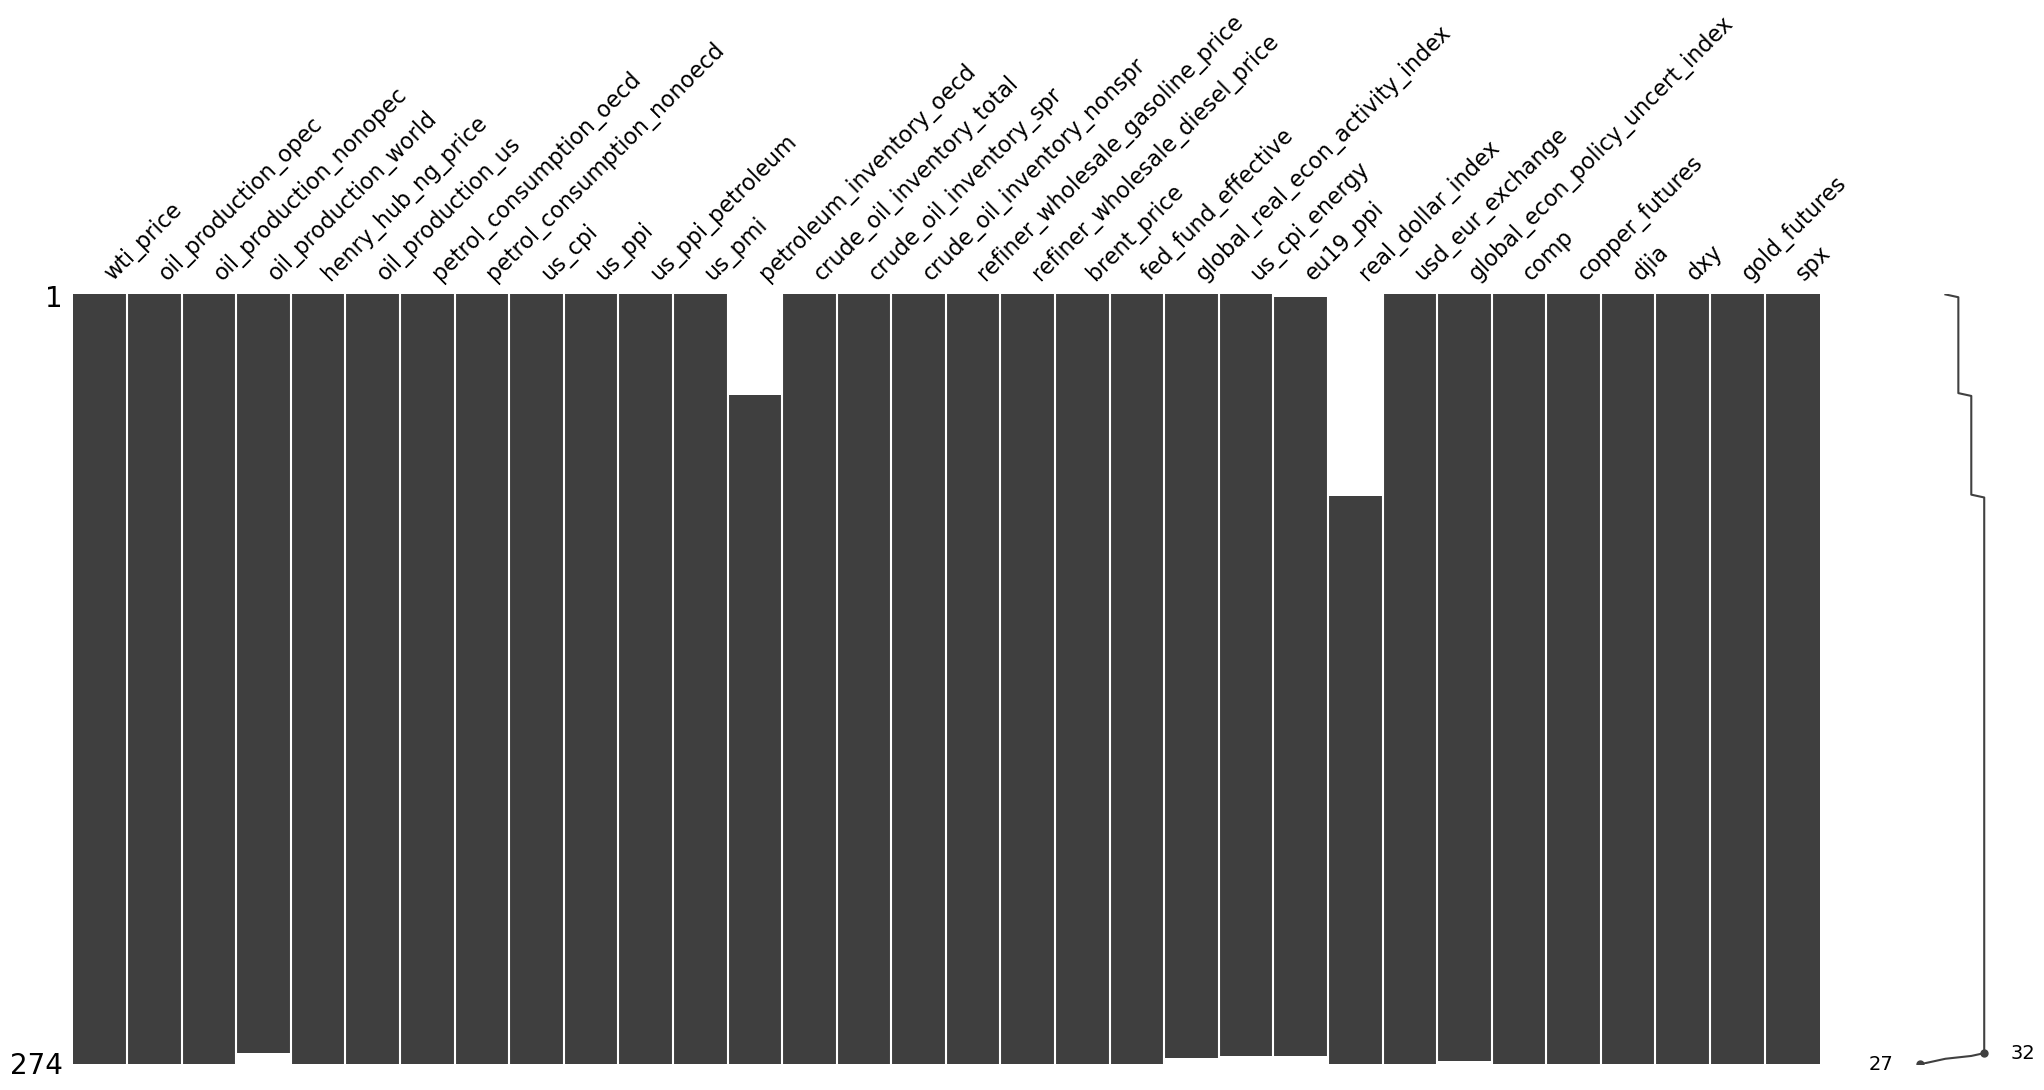

In [16]:
import missingno as msno

#Visualize the missing datausing "missingno" library
msno.matrix(df)
plt.show()

## Treat missing data

### 1. Set tolerances

In [17]:
### Tolerance for missing data %

print("""
Drop Columns:\t missing data (%) > tolerance_drop 
Drop Rows:\t tolerance_impute < missing data (%) < tolerance_drop
Impute Data:\t missing data (%) < tolerance_impute
""")

tolerance_drop = 10
tolerance_impute = 1

print('tolerance_drop =', tolerance_drop)
print('tolerance_impute =', tolerance_impute)


Drop Columns:	 missing data (%) > tolerance_drop 
Drop Rows:	 tolerance_impute < missing data (%) < tolerance_drop
Impute Data:	 missing data (%) < tolerance_impute

tolerance_drop = 10
tolerance_impute = 1


### 2. Drop Columns

#### Columns with NaN to drop

It is recommended to drop the  other data sources for the following featuers with more than the missing tolerance %

In [18]:
print('Columns with NaN to drop:')
drop_criteria = missing_stats['%'] > tolerance_drop 
columns_to_drop = missing_stats.loc[drop_criteria]
display(columns_to_drop.round(2))

Columns with NaN to drop:


,count,%
petroleum_inventory_oecd,36,13.14
real_dollar_index,72,26.28


#### Drop column and store

In [19]:
#drop select columns
dropped_col = df.drop(columns = columns_to_drop.index, inplace = False)

print('Original data:',df.shape)
print('Missing droppped:', dropped_col.shape)

Original data: (274, 32)
Missing droppped: (274, 30)


### 3. Impute missing data

In [20]:
print('Columns with NaN to impute:')
impute_criteria = missing_stats['%'] < tolerance_impute
columns_to_impute = missing_stats.loc[impute_criteria]
display(columns_to_impute.round(2))

Columns with NaN to impute:


,count,%
global_real_econ_activity_index,2,0.73
global_econ_policy_uncert_index,1,0.36


#### Plot where data is missiing

In [21]:
def plot_timeseries(df, target_feature):
    
    #Plot the target feature
    fig, ax = plt.subplots(figsize = (8,2))
    
    #line plot for target feature
    sns.lineplot(data = df, x = df.index, y = target_feature)

    #scatter plot for missing values
    df_nan = df.loc[df[target_feature].isnull()]
    #use medain value for y
    y_val = df[target_feature].median()    
    sns.scatterplot(data = df_nan, x =df_nan.index, y = y_val, marker="o", color="r")

    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    
    plt.show()

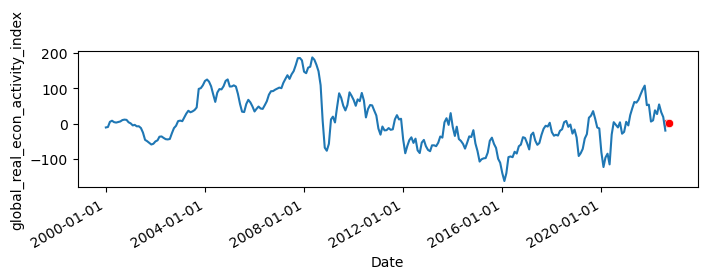

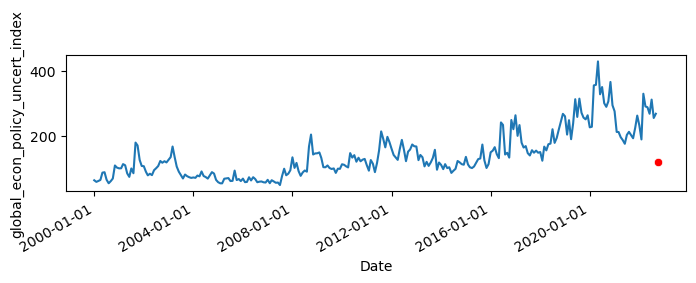

[None, None]

In [22]:
#plot the data and the missing data locatin 'TO BE IMPUTED'
[plot_timeseries(dropped_col, item) for item in columns_to_impute.index]

In [23]:
#Impute using bfill & ffil
for item in columns_to_impute.index:
    # Ffill imputation
    dropped_col[item] = dropped_col[item].fillna(method='ffill')
    # Bfill imputation
    dropped_col[item] = dropped_col[item].fillna(method='bfill')

In [24]:
print('Missing imputed:', dropped_col.shape)

Missing imputed: (274, 30)


### Drop Rows

In [25]:
#Count missing data
missing_stats = count_missing(dropped_col)

In [26]:
print('Columns with NaN to drop row:')
display(missing_stats.round(2))

Columns with NaN to drop row:


,count,%
oil_production_world,4,1.46
us_cpi_energy,3,1.09
eu19_ppi,4,1.46


In [27]:
dropped_row = dropped_col.dropna(axis = 0, inplace = False)

In [28]:
print('Missing droppped:', dropped_row.shape)

Missing droppped: (269, 30)


### Use df with no NaNs

In [29]:
df = dropped_row

## Explore data

### Check final DataFrame

In [30]:
#Display df head and tail
display_df(df, 7)

7 / 269 records from the dataframe tail:


Date,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
wti_price,71.7,83.2,91.6,108.5,101.8,109.6,114.8
oil_production_opec,27.9,27.8,28.6,28.2,28.6,28.1,28.4
oil_production_nonopec,64.9,64.7,64.9,65.7,64.7,65.1,64.8
oil_production_world,95875.8,95847.3,96799.3,97183.8,96325.7,96169.4,96792.9
henry_hub_ng_price,3.8,4.4,4.7,4.9,6.6,8.1,7.7
oil_production_us,11.6,11.4,11.3,11.7,11.7,11.6,11.8
petrol_consumption_oecd,47.7,44.7,46.8,46.2,44.7,45.2,46.4
petrol_consumption_nonoecd,54.6,52.9,54.0,52.6,52.7,53.3,54.1
us_cpi,2.8,2.8,2.8,2.9,2.9,2.9,3.0
us_ppi,2.5,2.5,2.5,2.6,2.7,2.7,2.8



7 / 269 records from the dataframe head:


Date,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01
wti_price,29.4,29.8,25.7,28.8,31.8,29.7,31.3
oil_production_opec,26.7,26.6,27.5,28.0,27.6,27.9,28.9
oil_production_nonopec,46.8,46.9,46.6,46.6,46.8,47.0,46.9
oil_production_world,74470.5,74439.0,75116.1,75639.6,75360.2,75983.0,76857.5
henry_hub_ng_price,2.7,2.8,3.0,3.6,4.3,4.0,4.4
oil_production_us,5.9,5.9,5.9,5.8,5.8,5.7,5.8
petrol_consumption_oecd,50.2,49.4,46.3,47.3,48.0,47.2,49.8
petrol_consumption_nonoecd,28.8,28.5,28.1,28.2,28.3,28.5,28.7
us_cpi,1.7,1.7,1.7,1.7,1.7,1.7,1.7
us_ppi,1.3,1.3,1.3,1.3,1.3,1.3,1.3


### Traget feature

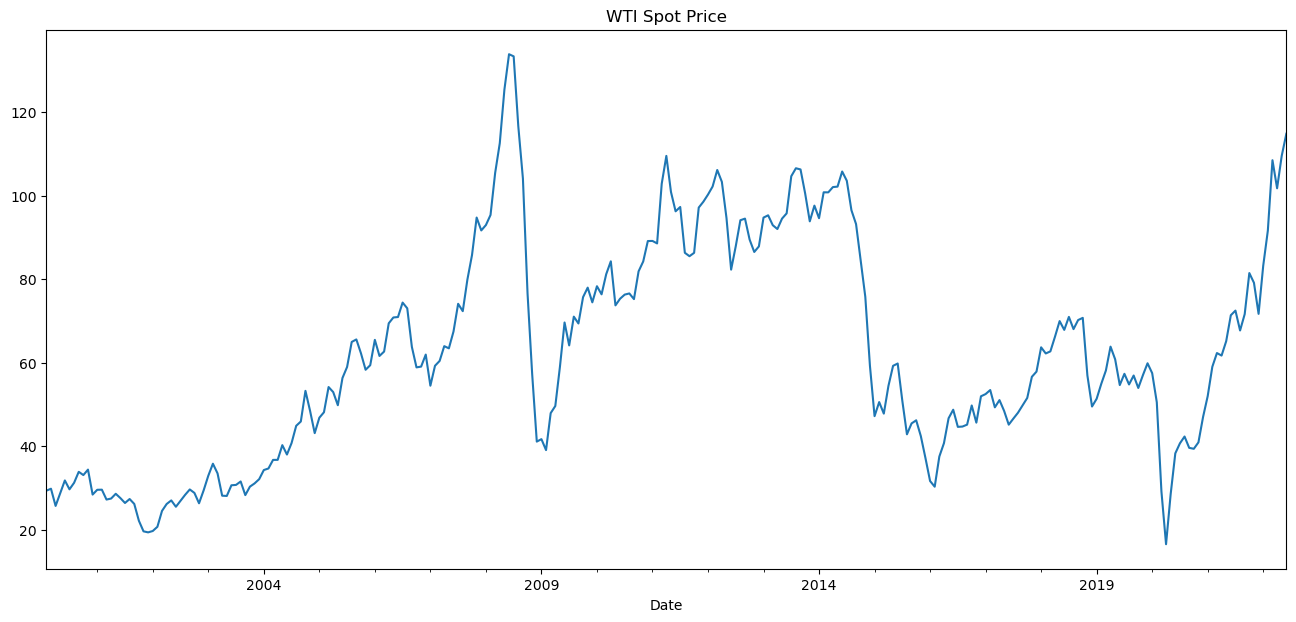

In [31]:
#Display the target feature
plt.figure(figsize = (16,7))
df['wti_price'].plot()
plt.title('WTI Spot Price')
plt.xlabel('Date')
plt.show()

### Summary Statistics

In [32]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
wti_price,269.0,62.05,25.99,16.55,40.94,59.04,81.89,133.88
oil_production_opec,269.0,29.03,1.96,22.35,28.18,29.29,30.45,32.39
oil_production_nonopec,269.0,55.65,5.91,46.62,50.89,54.34,60.71,67.46
oil_production_world,269.0,87089.82,7226.03,73916.41,82720.84,85934.43,94237.58,99859.49
henry_hub_ng_price,269.0,4.47,2.16,1.63,2.87,3.91,5.61,13.42
oil_production_us,269.0,7.45,2.49,3.97,5.45,5.88,9.38,13.00
petrol_consumption_oecd,269.0,47.49,2.32,35.02,46.21,47.45,48.96,52.88
petrol_consumption_nonoecd,269.0,42.05,8.35,28.13,34.28,42.93,50.02,54.63
us_cpi,269.0,2.22,0.30,1.70,1.98,2.24,2.42,2.95
us_ppi,269.0,1.81,0.30,1.29,1.60,1.88,2.01,2.76


### Histograms

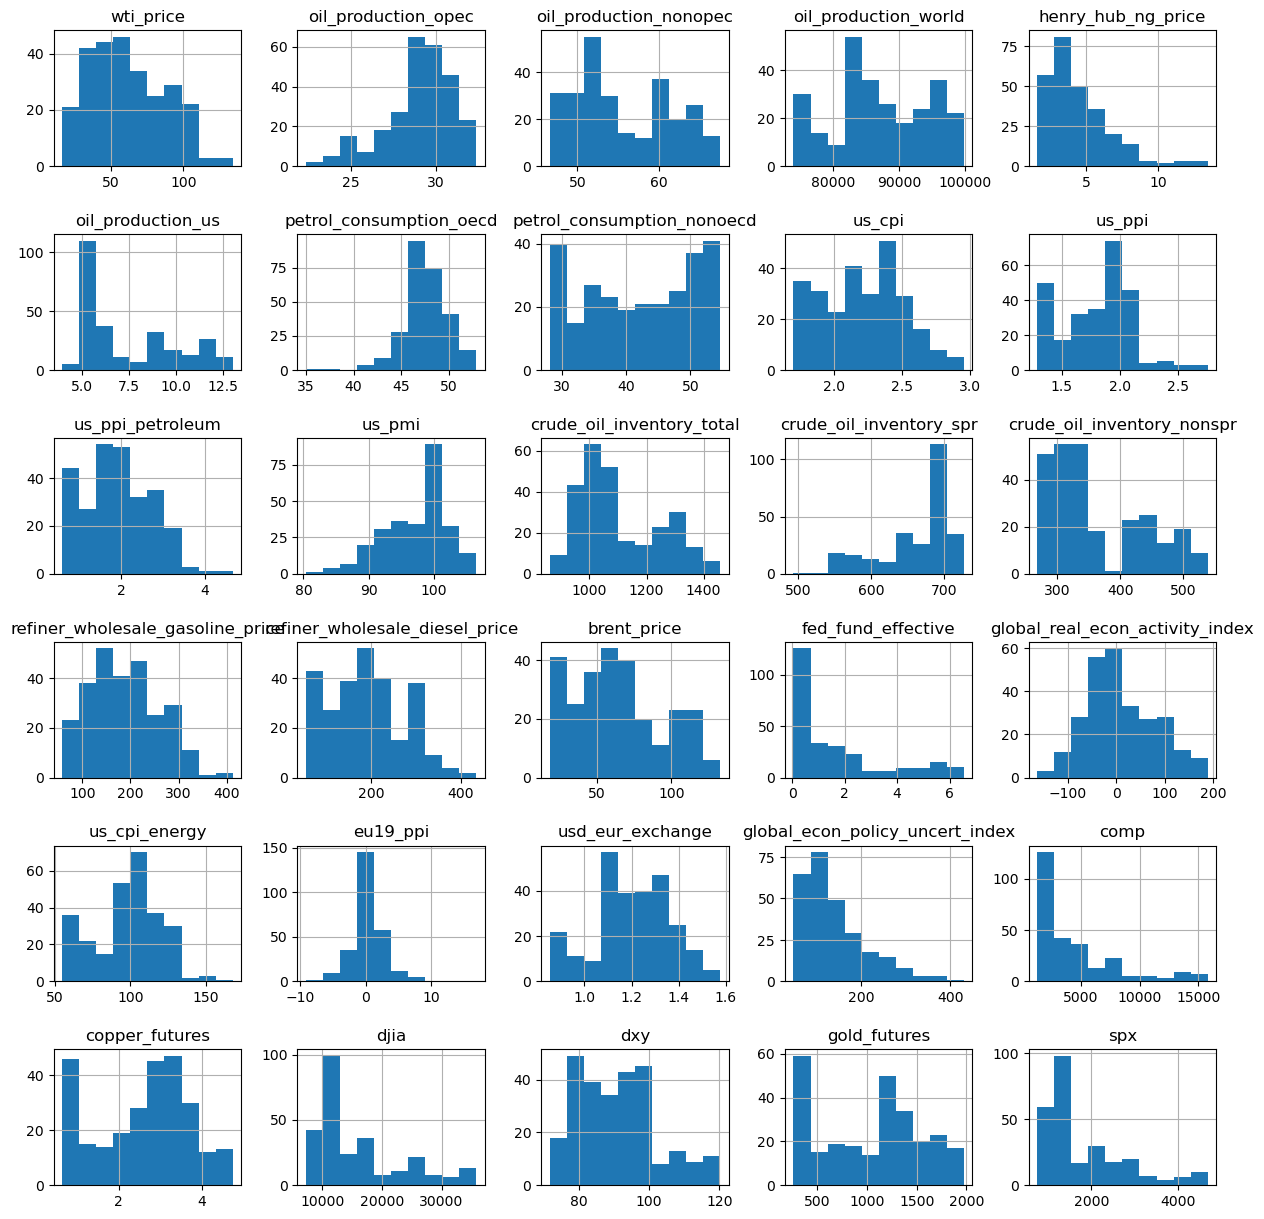

In [33]:
#Plot histogram of all  features
#Call plt.subplots_adjust() with an argument hspace=0.5 to adjust the spacing
#It's important you create legible and easy-to-read plots
df.hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);


## Store data

In [34]:
# Change direcotry to the 'data\raw' folder
path = ROOT_DIR + '\\data\\interim\\'

# Set a file name
file_save = path + 'step2_data_wrangling_wti_price.csv'
df.to_csv(file_save)

print('Save:\n', file_save)

Save:
 D:\gitProjects\springboard_capstone_1\Springboard_Capstone_01\data\interim\step2_data_wrangling_wti_price.csv
